# Audience Effect on Sudoku Performance - Data Analysis

**Research Question:** Does the presence of an audience (2 people) affect performance on easy Sudoku puzzles?

**Design:** Within-subjects design - each participant solved one Sudoku alone and one with an audience

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load and Prepare Data

In [2]:
# Load data
questionnaire = pd.read_csv('Final Questionnaire.csv')
feedback = pd.read_csv('Post-Sudoku Feedback.csv')

# Standardize participant codes (remove 'P' prefix, make lowercase)
questionnaire['Participant code (e.g., p01)'] = questionnaire['Participant code (e.g., p01)'].str.replace('P', '').str.replace('p', '').str.strip()
feedback['Participant code (e.g., P01)'] = feedback['Participant code (e.g., P01)'].str.replace('P', '').str.replace('p', '').str.strip()

# Convert time column to minutes
def time_to_minutes(time_str):
    """Convert time string (HH:MM:SS or MM:SS) to minutes"""
    try:
        parts = str(time_str).split(':')
        if len(parts) == 3:  # HH:MM:SS
            hours = int(parts[0])
            minutes = int(parts[1])
            seconds = int(parts[2])
            return hours * 60 + minutes + seconds / 60
        elif len(parts) == 2:  # MM:SS
            minutes = int(parts[0])
            seconds = int(parts[1])
            return minutes + seconds / 60
        else:
            return np.nan
    except:
        return np.nan

feedback['Time_minutes'] = feedback['How long did they take to perform the sudoku? HH:MM:SS'].apply(time_to_minutes)

# Clean up column names for easier access
feedback.columns = ['Timestamp', 'Participant', 'Condition', 'Order', 'Difficulty',
                    'Satisfaction', 'Nervousness', 'Time_raw', 'Time_minutes']

questionnaire.columns = ['Timestamp', 'Participant', 'People_known', 'Age', 'Gender',
                         'Nationality', 'Sudoku_frequency', 'Comfort_watched',
                         'Performance_experience', 'Performance_frequency']

print("Data loaded successfully!")
print(f"Participants: {feedback['Participant'].nunique()}")
print(f"Total observations: {len(feedback)}")

Data loaded successfully!
Participants: 23
Total observations: 46


In [3]:
# Check for participants with both conditions
participants_both_conditions = feedback.groupby('Participant')['Condition'].apply(
    lambda x: set(x) == {'Alone', 'Audience'}
)
valid_participants = participants_both_conditions[participants_both_conditions].index.tolist()

print(f"Participants with both conditions: {len(valid_participants)}")
print(f"Valid participants: {valid_participants}")

# Filter to only participants with both conditions
feedback_clean = feedback[feedback['Participant'].isin(valid_participants)].copy()

# Check data quality
print(f"\nMissing time data: {feedback_clean['Time_minutes'].isna().sum()}")
print(f"Observations per condition:")
print(feedback_clean['Condition'].value_counts())

Participants with both conditions: 23
Valid participants: ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']

Missing time data: 0
Observations per condition:
Condition
Alone       23
Audience    23
Name: count, dtype: int64


## 2. Descriptive Statistics

In [4]:
# Descriptive statistics by condition
desc_stats = feedback_clean.groupby('Condition').agg({
    'Time_minutes': ['mean', 'std', 'median', 'min', 'max'],
    'Difficulty': ['mean', 'std'],
    'Nervousness': ['mean', 'std'],
    'Satisfaction': ['mean', 'std']
}).round(2)

print("=" * 70)
print("DESCRIPTIVE STATISTICS BY CONDITION")
print("=" * 70)
print(desc_stats)
print("\n")

# Sample characteristics
print("=" * 70)
print("SAMPLE CHARACTERISTICS")
print("=" * 70)
print(f"Total N: {len(valid_participants)}")
print(f"Age: M = {questionnaire[questionnaire['Participant'].isin(valid_participants)]['Age'].mean():.1f}, "
      f"SD = {questionnaire[questionnaire['Participant'].isin(valid_participants)]['Age'].std():.1f}")
print(f"Gender: {questionnaire[questionnaire['Participant'].isin(valid_participants)]['Gender'].value_counts().to_dict()}")
print(f"\nSudoku Experience:")
print(questionnaire[questionnaire['Participant'].isin(valid_participants)]['Sudoku_frequency'].value_counts())

DESCRIPTIVE STATISTICS BY CONDITION
          Time_minutes                           Difficulty       Nervousness  \
                  mean   std median   min    max       mean   std        mean   
Condition                                                                       
Alone            12.15  6.06  10.73  4.55  22.72       2.39  1.23        1.96   
Audience         13.03  4.93  12.92  5.23  22.87       2.57  0.90        2.78   

                Satisfaction        
            std         mean   std  
Condition                           
Alone      1.02         2.70  1.11  
Audience   1.13         2.87  0.87  


SAMPLE CHARACTERISTICS
Total N: 23
Age: M = 26.0, SD = 2.5
Gender: {'Male': 16, 'Female': 7}

Sudoku Experience:
Sudoku_frequency
Occasionally           13
Never                   7
Sometimes (monthly)     2
Often (weekly)          1
Name: count, dtype: int64


## 3. Main Result: Raincloud Plot - Completion Time by Condition

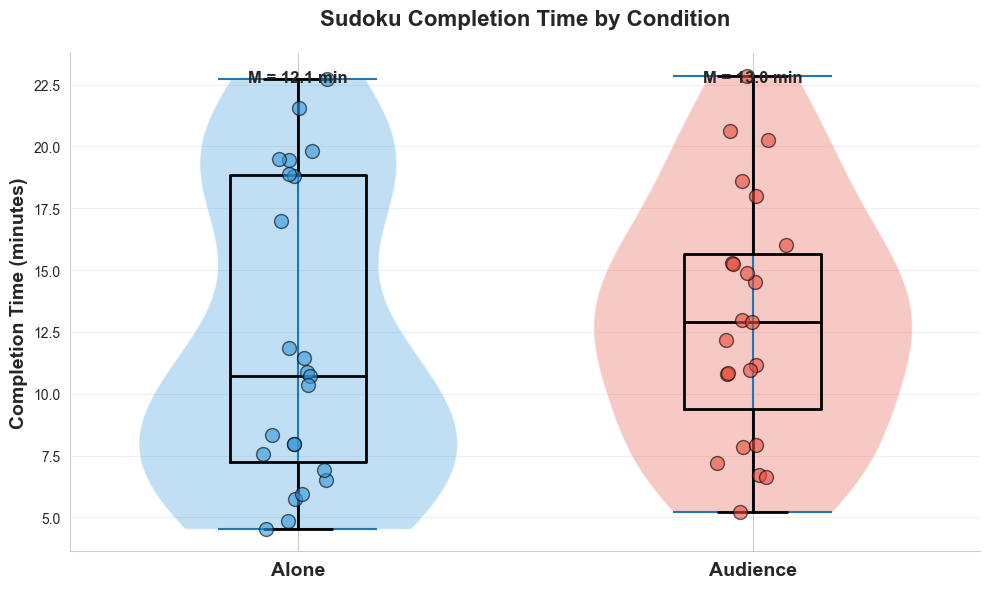

Alone: M = 12.15 min, SD = 6.06 min
Audience: M = 13.03 min, SD = 4.93 min


In [5]:
# Create raincloud plot for completion time
fig, ax = plt.subplots(figsize=(10, 6))

# Violin plot (distribution)
parts = ax.violinplot([feedback_clean[feedback_clean['Condition'] == 'Alone']['Time_minutes'].dropna(),
                        feedback_clean[feedback_clean['Condition'] == 'Audience']['Time_minutes'].dropna()],
                       positions=[1, 2], widths=0.7, showmeans=False, showmedians=False)

# Color the violin plots
colors = ['#3498db', '#e74c3c']
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.3)

# Box plot overlay
bp = ax.boxplot([feedback_clean[feedback_clean['Condition'] == 'Alone']['Time_minutes'].dropna(),
                  feedback_clean[feedback_clean['Condition'] == 'Audience']['Time_minutes'].dropna()],
                 positions=[1, 2], widths=0.3, showfliers=False,
                 boxprops=dict(linewidth=2),
                 medianprops=dict(linewidth=2, color='black'),
                 whiskerprops=dict(linewidth=2),
                 capprops=dict(linewidth=2))

# Individual data points with jitter
np.random.seed(42)
for i, condition in enumerate(['Alone', 'Audience']):
    data = feedback_clean[feedback_clean['Condition'] == condition]['Time_minutes'].dropna()
    x = np.random.normal(i + 1, 0.04, size=len(data))
    ax.scatter(x, data, alpha=0.6, s=100, color=colors[i], edgecolors='black', linewidth=1, zorder=3)

# Formatting
ax.set_xticks([1, 2])
ax.set_xticklabels(['Alone', 'Audience'], fontsize=14, fontweight='bold')
ax.set_ylabel('Completion Time (minutes)', fontsize=14, fontweight='bold')
ax.set_title('Sudoku Completion Time by Condition', fontsize=16, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add mean values as text
alone_mean = feedback_clean[feedback_clean['Condition'] == 'Alone']['Time_minutes'].mean()
audience_mean = feedback_clean[feedback_clean['Condition'] == 'Audience']['Time_minutes'].mean()
ax.text(1, ax.get_ylim()[1] * 0.95, f'M = {alone_mean:.1f} min', ha='center', fontsize=12, fontweight='bold')
ax.text(2, ax.get_ylim()[1] * 0.95, f'M = {audience_mean:.1f} min', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Alone: M = {alone_mean:.2f} min, SD = {feedback_clean[feedback_clean['Condition'] == 'Alone']['Time_minutes'].std():.2f} min")
print(f"Audience: M = {audience_mean:.2f} min, SD = {feedback_clean[feedback_clean['Condition'] == 'Audience']['Time_minutes'].std():.2f} min")

## 4. Raincloud Plot - Nervousness by Condition

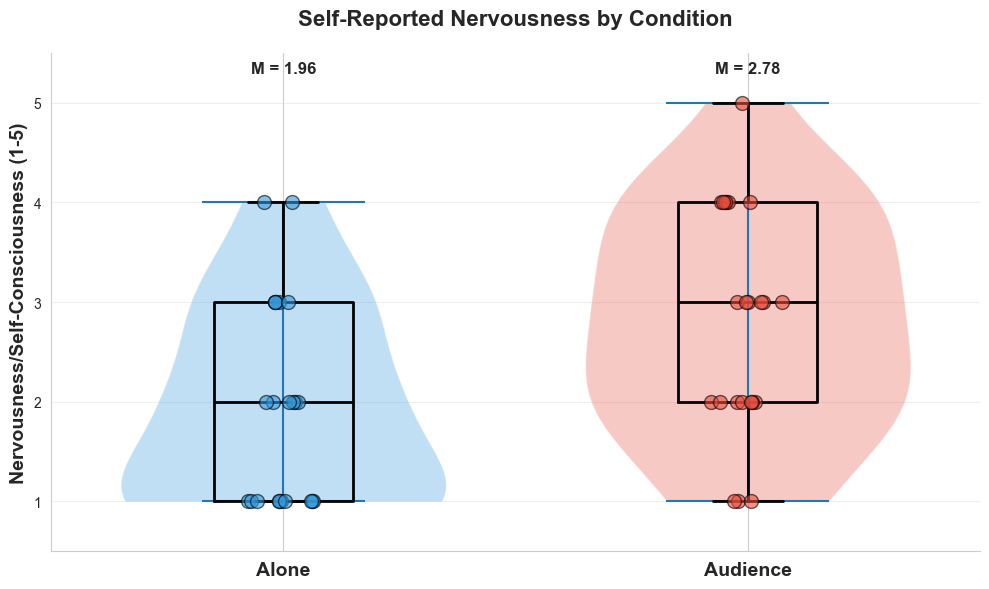

Alone: M = 1.96, SD = 1.02
Audience: M = 2.78, SD = 1.13


In [6]:
# Create raincloud plot for nervousness
fig, ax = plt.subplots(figsize=(10, 6))

# Violin plot
parts = ax.violinplot([feedback_clean[feedback_clean['Condition'] == 'Alone']['Nervousness'].dropna(),
                        feedback_clean[feedback_clean['Condition'] == 'Audience']['Nervousness'].dropna()],
                       positions=[1, 2], widths=0.7, showmeans=False, showmedians=False)

# Color the violin plots
colors = ['#3498db', '#e74c3c']
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.3)

# Box plot overlay
bp = ax.boxplot([feedback_clean[feedback_clean['Condition'] == 'Alone']['Nervousness'].dropna(),
                  feedback_clean[feedback_clean['Condition'] == 'Audience']['Nervousness'].dropna()],
                 positions=[1, 2], widths=0.3, showfliers=False,
                 boxprops=dict(linewidth=2),
                 medianprops=dict(linewidth=2, color='black'),
                 whiskerprops=dict(linewidth=2),
                 capprops=dict(linewidth=2))

# Individual data points with jitter
np.random.seed(42)
for i, condition in enumerate(['Alone', 'Audience']):
    data = feedback_clean[feedback_clean['Condition'] == condition]['Nervousness'].dropna()
    x = np.random.normal(i + 1, 0.04, size=len(data))
    ax.scatter(x, data, alpha=0.6, s=100, color=colors[i], edgecolors='black', linewidth=1, zorder=3)

# Formatting
ax.set_xticks([1, 2])
ax.set_xticklabels(['Alone', 'Audience'], fontsize=14, fontweight='bold')
ax.set_ylabel('Nervousness/Self-Consciousness (1-5)', fontsize=14, fontweight='bold')
ax.set_title('Self-Reported Nervousness by Condition', fontsize=16, fontweight='bold', pad=20)
ax.set_ylim(0.5, 5.5)
ax.grid(axis='y', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add mean values
alone_mean = feedback_clean[feedback_clean['Condition'] == 'Alone']['Nervousness'].mean()
audience_mean = feedback_clean[feedback_clean['Condition'] == 'Audience']['Nervousness'].mean()
ax.text(1, 5.3, f'M = {alone_mean:.2f}', ha='center', fontsize=12, fontweight='bold')
ax.text(2, 5.3, f'M = {audience_mean:.2f}', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Alone: M = {alone_mean:.2f}, SD = {feedback_clean[feedback_clean['Condition'] == 'Alone']['Nervousness'].std():.2f}")
print(f"Audience: M = {audience_mean:.2f}, SD = {feedback_clean[feedback_clean['Condition'] == 'Audience']['Nervousness'].std():.2f}")

## 5. Paired Plot - Individual Changes Across Conditions

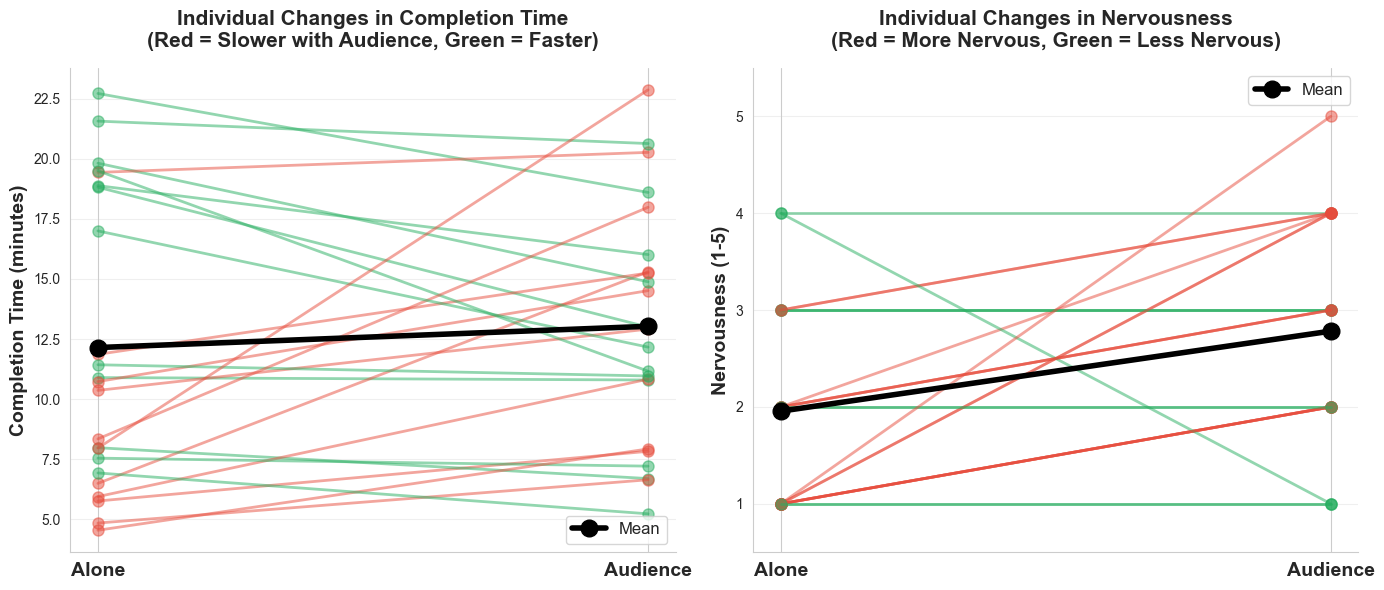


11/23 participants (47.8%) were slower with audience
14/23 participants (60.9%) were more nervous with audience


In [7]:
# Create paired plot showing within-subject changes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Prepare paired data
paired_data = []
for participant in valid_participants:
    p_data = feedback_clean[feedback_clean['Participant'] == participant]
    if len(p_data) == 2:
        alone_time = p_data[p_data['Condition'] == 'Alone']['Time_minutes'].values[0]
        audience_time = p_data[p_data['Condition'] == 'Audience']['Time_minutes'].values[0]
        alone_nerv = p_data[p_data['Condition'] == 'Alone']['Nervousness'].values[0]
        audience_nerv = p_data[p_data['Condition'] == 'Audience']['Nervousness'].values[0]
        paired_data.append({
            'Participant': participant,
            'Alone_Time': alone_time,
            'Audience_Time': audience_time,
            'Alone_Nerv': alone_nerv,
            'Audience_Nerv': audience_nerv
        })

paired_df = pd.DataFrame(paired_data)

# Plot 1: Completion Time
for _, row in paired_df.iterrows():
    # Red = slower with audience (audience time > alone time) = WORSE performance
    # Green = faster with audience (audience time < alone time) = BETTER performance
    color = '#e74c3c' if row['Audience_Time'] > row['Alone_Time'] else '#27ae60'
    ax1.plot([1, 2], [row['Alone_Time'], row['Audience_Time']],
             'o-', alpha=0.5, linewidth=2, markersize=8, color=color)

ax1.plot([1, 2], [paired_df['Alone_Time'].mean(), paired_df['Audience_Time'].mean()],
         'ko-', linewidth=4, markersize=12, label='Mean', zorder=10)

ax1.set_xticks([1, 2])
ax1.set_xticklabels(['Alone', 'Audience'], fontsize=14, fontweight='bold')
ax1.set_ylabel('Completion Time (minutes)', fontsize=14, fontweight='bold')
ax1.set_title('Individual Changes in Completion Time\n(Red = Slower with Audience, Green = Faster)',
              fontsize=15, fontweight='bold', pad=15)
ax1.grid(axis='y', alpha=0.3)
ax1.legend(fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Plot 2: Nervousness
for _, row in paired_df.iterrows():
    color = '#e74c3c' if row['Audience_Nerv'] > row['Alone_Nerv'] else '#27ae60'
    ax2.plot([1, 2], [row['Alone_Nerv'], row['Audience_Nerv']],
             'o-', alpha=0.5, linewidth=2, markersize=8, color=color)

ax2.plot([1, 2], [paired_df['Alone_Nerv'].mean(), paired_df['Audience_Nerv'].mean()],
         'ko-', linewidth=4, markersize=12, label='Mean', zorder=10)

ax2.set_xticks([1, 2])
ax2.set_xticklabels(['Alone', 'Audience'], fontsize=14, fontweight='bold')
ax2.set_ylabel('Nervousness (1-5)', fontsize=14, fontweight='bold')
ax2.set_title('Individual Changes in Nervousness\n(Red = More Nervous, Green = Less Nervous)',
              fontsize=15, fontweight='bold', pad=15)
ax2.set_ylim(0.5, 5.5)
ax2.grid(axis='y', alpha=0.3)
ax2.legend(fontsize=12)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Calculate percentage of participants who got slower/more nervous
slower = (paired_df['Audience_Time'] > paired_df['Alone_Time']).sum()
more_nervous = (paired_df['Audience_Nerv'] > paired_df['Alone_Nerv']).sum()
print(f"\n{slower}/{len(paired_df)} participants ({slower/len(paired_df)*100:.1f}%) were slower with audience")
print(f"{more_nervous}/{len(paired_df)} participants ({more_nervous/len(paired_df)*100:.1f}%) were more nervous with audience")

## 7. Control Checks - Difficulty & Satisfaction

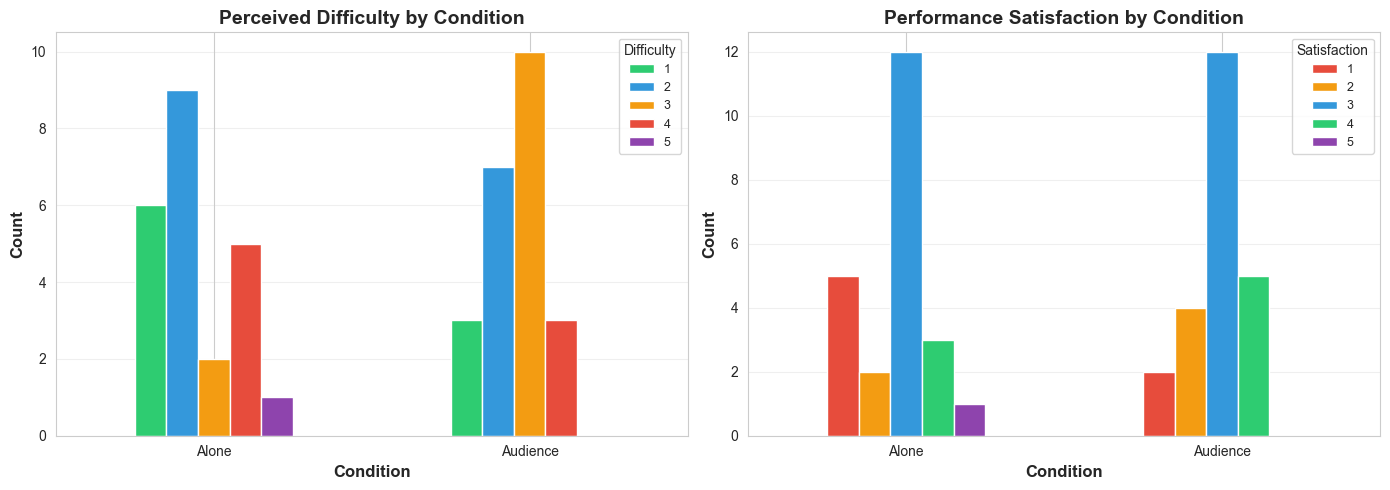

CONTROL CHECKS
Difficulty: t = -0.624, p = 0.5390
Satisfaction: t = -0.749, p = 0.4620

Note: Sudokus should be equally difficult; satisfaction might differ due to audience effect


In [8]:
# Check if perceived difficulty differs between conditions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Difficulty
difficulty_counts = feedback_clean.groupby(['Condition', 'Difficulty']).size().unstack(fill_value=0)
difficulty_counts.plot(kind='bar', ax=ax1, color=['#2ecc71', '#3498db', '#f39c12', '#e74c3c', '#8e44ad'])
ax1.set_title('Perceived Difficulty by Condition', fontsize=14, fontweight='bold')
ax1.set_xlabel('Condition', fontsize=12, fontweight='bold')
ax1.set_ylabel('Count', fontsize=12, fontweight='bold')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.legend(title='Difficulty', title_fontsize=10, fontsize=9)
ax1.grid(axis='y', alpha=0.3)

# Satisfaction
satisfaction_counts = feedback_clean.groupby(['Condition', 'Satisfaction']).size().unstack(fill_value=0)
satisfaction_counts.plot(kind='bar', ax=ax2, color=['#e74c3c', '#f39c12', '#3498db', '#2ecc71', '#8e44ad'])
ax2.set_title('Performance Satisfaction by Condition', fontsize=14, fontweight='bold')
ax2.set_xlabel('Condition', fontsize=12, fontweight='bold')
ax2.set_ylabel('Count', fontsize=12, fontweight='bold')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.legend(title='Satisfaction', title_fontsize=10, fontsize=9)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical tests
print("CONTROL CHECKS")
print("=" * 50)
t_diff, p_diff = stats.ttest_rel(
    paired_df.merge(feedback_clean[feedback_clean['Condition']=='Alone'][['Participant', 'Difficulty']], on='Participant')['Difficulty'],
    paired_df.merge(feedback_clean[feedback_clean['Condition']=='Audience'][['Participant', 'Difficulty']], on='Participant')['Difficulty']
)
print(f"Difficulty: t = {t_diff:.3f}, p = {p_diff:.4f}")

t_sat, p_sat = stats.ttest_rel(
    paired_df.merge(feedback_clean[feedback_clean['Condition']=='Alone'][['Participant', 'Satisfaction']], on='Participant')['Satisfaction'],
    paired_df.merge(feedback_clean[feedback_clean['Condition']=='Audience'][['Participant', 'Satisfaction']], on='Participant')['Satisfaction']
)
print(f"Satisfaction: t = {t_sat:.3f}, p = {p_sat:.4f}")
print("\nNote: Sudokus should be equally difficult; satisfaction might differ due to audience effect")

## 8. Exploratory Analysis - Individual Differences as Moderators

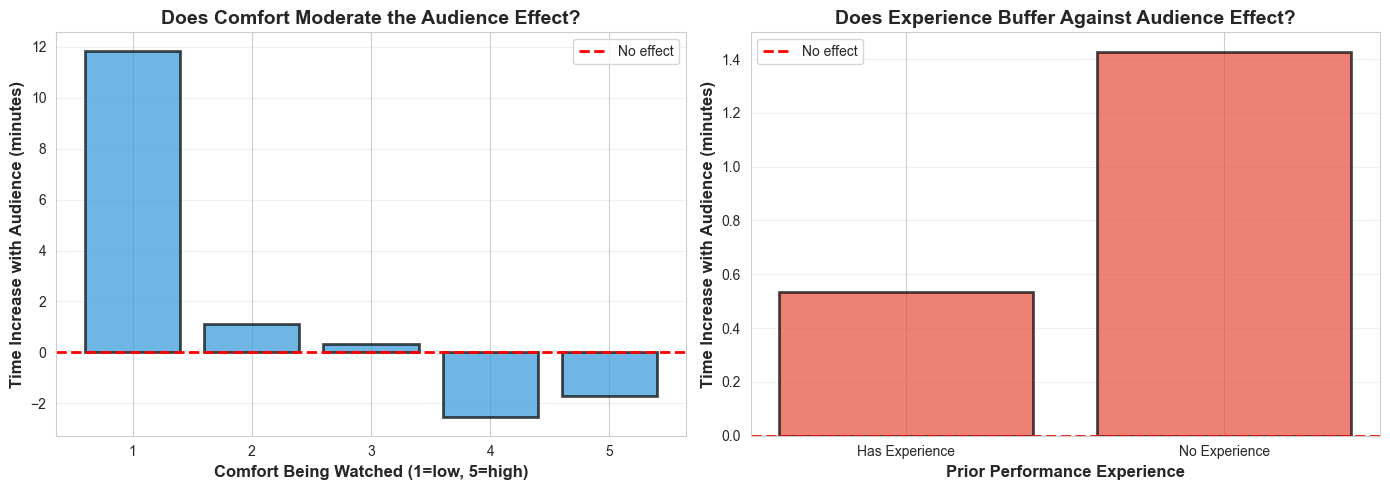

EXPLORATORY MODERATOR ANALYSIS

Correlation: Comfort being watched × Audience effect on time
r = -0.553
Interpretation: Negative r = more comfortable → smaller audience effect

Mean time increase by performance experience:
                        mean  std  count
Performance_experience                  
No                       1.4  3.1      9
Yes                      0.5  6.5     14

Note: Small sample sizes - interpret with caution


In [9]:
# Merge with questionnaire data
merged = paired_df.merge(questionnaire[['Participant', 'Comfort_watched', 'Performance_experience']],
                         on='Participant', how='left')

# Calculate audience effect (difference score)
merged['Time_Difference'] = merged['Audience_Time'] - merged['Alone_Time']
merged['Nerv_Difference'] = merged['Audience_Nerv'] - merged['Alone_Nerv']

# Plot 1: Comfort being watched vs. audience effect
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

comfort_effect = merged.groupby('Comfort_watched')['Time_Difference'].mean()
ax1.bar(comfort_effect.index, comfort_effect.values, color='#3498db', alpha=0.7, edgecolor='black', linewidth=2)
ax1.axhline(y=0, color='red', linestyle='--', linewidth=2, label='No effect')
ax1.set_xlabel('Comfort Being Watched (1=low, 5=high)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Time Increase with Audience (minutes)', fontsize=12, fontweight='bold')
ax1.set_title('Does Comfort Moderate the Audience Effect?', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.legend()

# Plot 2: Performance experience vs. audience effect
perf_mapping = {'Yes': 'Has Experience', 'No': 'No Experience'}
merged['Perf_Exp_Label'] = merged['Performance_experience'].map(perf_mapping)
perf_effect = merged.groupby('Perf_Exp_Label')['Time_Difference'].mean()

ax2.bar(perf_effect.index, perf_effect.values, color='#e74c3c', alpha=0.7, edgecolor='black', linewidth=2)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=2, label='No effect')
ax2.set_xlabel('Prior Performance Experience', fontsize=12, fontweight='bold')
ax2.set_ylabel('Time Increase with Audience (minutes)', fontsize=12, fontweight='bold')
ax2.set_title('Does Experience Buffer Against Audience Effect?', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Correlation analysis
print("EXPLORATORY MODERATOR ANALYSIS")
print("=" * 60)
print(f"\nCorrelation: Comfort being watched × Audience effect on time")
corr_comfort = merged[['Comfort_watched', 'Time_Difference']].corr().iloc[0, 1]
print(f"r = {corr_comfort:.3f}")
print("Interpretation: Negative r = more comfortable → smaller audience effect")

print(f"\nMean time increase by performance experience:")
print(merged.groupby('Performance_experience')['Time_Difference'].agg(['mean', 'std', 'count']).round(1))
print("\nNote: Small sample sizes - interpret with caution")

## 9. Practice Effect Analysis - Did Participants Improve on Second Sudoku?

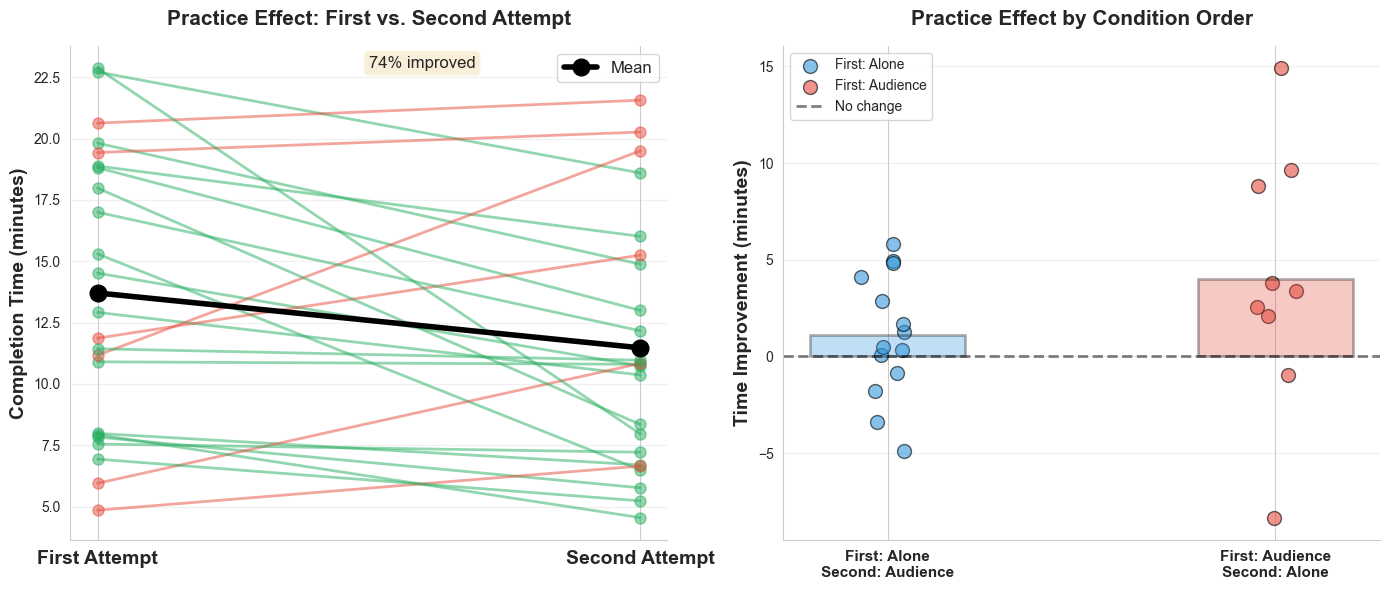

PRACTICE EFFECT ANALYSIS

First attempt:  M = 13.71 min, SD = 5.70 min
Second attempt: M = 11.47 min, SD = 5.12 min
Mean improvement: 2.23 min (SD = 4.93)

Paired t-test: t(22) = 2.173, p = 0.0408
Effect: ***SIGNIFICANT PRACTICE EFFECT***

17/23 participants (73.9%) were faster on second attempt

----------------------------------------------------------------------
PRACTICE EFFECT BY CONDITION ORDER
----------------------------------------------------------------------
First Alone    → Second: M = 1.11 min improvement (n=14)
First Audience → Second: M = 3.98 min improvement (n=9)

Interpretation: Positive values = improvement (faster on 2nd attempt)


In [10]:
# Prepare data comparing first vs second attempt (regardless of condition)
practice_data = []
for participant in valid_participants:
    p_data = feedback_clean[feedback_clean['Participant'] == participant]
    if len(p_data) == 2:
        first = p_data[p_data['Order'] == 'First']
        second = p_data[p_data['Order'] == 'Second']

        if len(first) == 1 and len(second) == 1:
            practice_data.append({
                'Participant': participant,
                'First_Time': first['Time_minutes'].values[0],
                'Second_Time': second['Time_minutes'].values[0],
                'First_Condition': first['Condition'].values[0],
                'Second_Condition': second['Condition'].values[0]
            })

practice_df = pd.DataFrame(practice_data)
practice_df['Improvement'] = practice_df['First_Time'] - practice_df['Second_Time']  # Positive = faster second time

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Individual changes from first to second attempt
for _, row in practice_df.iterrows():
    color = '#27ae60' if row['Second_Time'] < row['First_Time'] else '#e74c3c'
    ax1.plot([1, 2], [row['First_Time'], row['Second_Time']],
             'o-', alpha=0.5, linewidth=2, markersize=8, color=color)

# Add mean line
ax1.plot([1, 2], [practice_df['First_Time'].mean(), practice_df['Second_Time'].mean()],
         'ko-', linewidth=4, markersize=12, label='Mean', zorder=10)

ax1.set_xticks([1, 2])
ax1.set_xticklabels(['First Attempt', 'Second Attempt'], fontsize=14, fontweight='bold')
ax1.set_ylabel('Completion Time (minutes)', fontsize=14, fontweight='bold')
ax1.set_title('Practice Effect: First vs. Second Attempt', fontsize=15, fontweight='bold', pad=15)
ax1.grid(axis='y', alpha=0.3)
ax1.legend(fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Add text annotation
improvement_pct = (practice_df['Improvement'] > 0).sum() / len(practice_df) * 100
ax1.text(0.5, 0.98, f'{improvement_pct:.0f}% improved',
         transform=ax1.transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Improvement by condition order
order_colors = {'Alone': '#3498db', 'Audience': '#e74c3c'}
for condition in ['Alone', 'Audience']:
    mask = practice_df['First_Condition'] == condition
    x_pos = 1 if condition == 'Alone' else 2
    improvements = practice_df[mask]['Improvement']

    # Scatter with jitter
    x_jitter = np.random.normal(x_pos, 0.04, size=len(improvements))
    ax2.scatter(x_jitter, improvements, alpha=0.6, s=100,
                color=order_colors[condition], edgecolors='black',
                linewidth=1, label=f'First: {condition}')

    # Add mean bar
    mean_imp = improvements.mean()
    ax2.bar(x_pos, mean_imp, width=0.4, alpha=0.3,
            color=order_colors[condition], edgecolor='black', linewidth=2)

ax2.axhline(y=0, color='black', linestyle='--', linewidth=2, alpha=0.5, label='No change')
ax2.set_xticks([1, 2])
ax2.set_xticklabels(['First: Alone\nSecond: Audience', 'First: Audience\nSecond: Alone'],
                    fontsize=11, fontweight='bold')
ax2.set_ylabel('Time Improvement (minutes)', fontsize=14, fontweight='bold')
ax2.set_title('Practice Effect by Condition Order', fontsize=15, fontweight='bold', pad=15)
ax2.grid(axis='y', alpha=0.3)
ax2.legend(fontsize=10)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Statistics
print("=" * 70)
print("PRACTICE EFFECT ANALYSIS")
print("=" * 70)
print(f"\nFirst attempt:  M = {practice_df['First_Time'].mean():.2f} min, SD = {practice_df['First_Time'].std():.2f} min")
print(f"Second attempt: M = {practice_df['Second_Time'].mean():.2f} min, SD = {practice_df['Second_Time'].std():.2f} min")
print(f"Mean improvement: {practice_df['Improvement'].mean():.2f} min (SD = {practice_df['Improvement'].std():.2f})")

# Paired t-test
t_practice, p_practice = stats.ttest_rel(practice_df['First_Time'], practice_df['Second_Time'])
print(f"\nPaired t-test: t({len(practice_df)-1}) = {t_practice:.3f}, p = {p_practice:.4f}")
print(f"Effect: {'***SIGNIFICANT PRACTICE EFFECT***' if p_practice < 0.05 else 'Not significant'}")

improved = (practice_df['Improvement'] > 0).sum()
print(f"\n{improved}/{len(practice_df)} participants ({improved/len(practice_df)*100:.1f}%) were faster on second attempt")

# Check if practice effect differs by condition order
print("\n" + "-" * 70)
print("PRACTICE EFFECT BY CONDITION ORDER")
print("-" * 70)
for first_cond in ['Alone', 'Audience']:
    mask = practice_df['First_Condition'] == first_cond
    mean_imp = practice_df[mask]['Improvement'].mean()
    n = mask.sum()
    print(f"First {first_cond:8s} → Second: M = {mean_imp:.2f} min improvement (n={n})")

print("\nInterpretation: Positive values = improvement (faster on 2nd attempt)")
print("=" * 70)

In [11]:
pip install pingouin

  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.6 MB 932.9 kB/s eta 0:00:10
   --- ------------------------------------ 0.8/9.6 MB 882.6 kB/s eta 0:00:11
   --- ------------------------------------ 0.8/9.6 MB 882.6 kB/s eta 0:00:11
   ---- ----------------------------------- 1.0/9.6 MB 853.0 kB/s eta 0:00:11
   ----- ---------------------------------- 1.3/9.6 MB 860.2 kB/s eta 0:00:10
   ----- ---------------------------------- 1.3/9.6 MB 860.2 kB/s eta 0:00:10
   ------ --------------------------------- 1.6/9.6 MB 847.3 kB/s eta 0:00:10
   ------- -------------------------------- 1.8/9.6 MB 853.0 kB/s eta 0:00:10
   ------- -------------------------

In [13]:
import pandas as pd
import pingouin as pg

df = pd.read_csv('Processed_Feedback_Data.csv').copy()

# --- CLEAN COLUMNS ---
df["Participant"] = df["Participant"].astype("category")
df["Condition"] = df["Condition"].astype("category")
df["Order"] = df["Order"].astype("category")

# --- CREATE BETWEEN-SUBJECT ORDER GROUP ---
# Determine which condition each participant did on their FIRST trial
first_trials = df[df["Order"] == "First"][["Participant", "Condition"]]
first_trials["OrderGroup"] = first_trials["Condition"].map({
    "Alone": "AloneFirst",
    "Audience": "AudienceFirst"
})

# Merge back onto whole df
df = df.merge(first_trials[["Participant", "OrderGroup"]], on="Participant", how="left")
df["OrderGroup"] = df["OrderGroup"].astype("category")

# --- RUN THE MIXED ANOVA ---
aov = pg.mixed_anova(
    dv="Time_minutes",
    within="Condition",
    between="OrderGroup",
    subject="Participant",
    data=df
)

print(aov)

# --- MEANS FOR INTERPRETATION ---
means = df.groupby(["OrderGroup", "Condition"])["Time_minutes"].mean()
print("\nMeans (in minutes):")
print(means)


        Source         SS  DF1  DF2         MS         F     p-unc       np2  \
0   OrderGroup   0.004939    1   20   0.004939  0.000096  0.992263  0.000005   
1    Condition   6.200006    1   20   6.200006  0.506347  0.484942  0.024692   
2  Interaction  66.702742    1   20  66.702742  5.447533  0.030141  0.214069   

   eps  
0  NaN  
1  1.0  
2  NaN  

Means (in minutes):
OrderGroup     Condition
AloneFirst     Alone        13.152381
               Audience     12.041667
AudienceFirst  Alone        10.570833
               Audience     14.572222
Name: Time_minutes, dtype: float64
